In [1]:
import numpy as np  # for array stuff and random
import random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib import style  # to make pretty charts because it matters.
import os

import torch
import gym
from gym import spaces
from gym import envs
from gym.utils import seeding, EzPickle

In [2]:
seed = 543 # Do not change this
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.set_deterministic(True)
    #torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.deterministic = True

In [3]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C

In [4]:
model = A2C.load("PPO_test_modflow_choshui_5")
env = gym.make('pumpingAllocation-v7')

S_max = env.max_storage
D_min, D_max = np.min(env.demands), np.max(env.demands)
In_min, In_max = np.min(env.rivers), np.max(env.rivers)

#Pick scenerio
scenerio = 8

p = [0]*11
p[scenerio-1] = 1
#p = [0,0,0,0,0,0,0,0.5, 0.5, 0]

env.river_p = p
env.demands_p = [1, 0, 0, 0]

SW, GW, Sup, D = [], [], [], []
deficit=[]
S, h, inflow = [], [], []
Z_mean = []
rewards = []
env.ifRandtt = False

for i in range(1):
    print('----------test',i+1,'start-------------')
    state = env.reset()
    total_step=0
    while True:
        action, _states = model.predict(state,deterministic=True )
        #print(action, _states)
        next_state, reward, done, info = env.step(action)
        #print(next_state,reward,done)
        
        #還原標準化
        storage = (state[0]+1)/2*S_max
        #Zmin_before = (state[1]+1)/2*100-100
        #Zmin_after = (next_state[1]+1)/2*100-100
        demand = (state[1]+1)/2*(D_max-D_min+400)+D_min-200
        inf = (state[2]+1)/2*(In_max-In_min)+In_min
        
        sw = env.SW
        gw = env.GW
        
        print(f'第{total_step+1:2.0f}旬, 水庫水量:{storage:4.0f}, Action:{action}, SW、GW:[{action[0]*16*86.4:3.0f}, {action[1]*120*2.151:3.0f}], 需水量:{demand:4.0f}, Reward: {reward:.1f}')
        
        SW.append(sw)
        GW.append(gw)
        Sup.append(sw+gw)
        D.append(demand)
        deficit.append(demand-sw-gw)
        S.append(storage)
        #h.append(Zmin_before)
        #Z_mean.append(env.Zmean)
        inflow.append(inf)
        rewards.append(reward)
        
        
        state = next_state
        total_step+=1

        if done:
            break


C:\Users\johnn\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
C:\Users\johnn\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


----------test 1 start-------------
第 1旬, 水庫水量: 400, Action:[1 0], SW、GW:[1382,   0], 需水量:5131, Reward: -4.2
第 2旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:4951, Reward: 0.7
第 3旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:5051, Reward: 0.6
第 4旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:5559, Reward: 0.5
第 5旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:5359, Reward: 0.5
第 6旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:5419, Reward: 0.5
第 7旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:6303, Reward: 0.3
第 8旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:6163, Reward: 0.3
第 9旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:6253, Reward: 0.3
第10旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:7341, Reward: 0.1
第11旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:7271, Reward: 0.1
第12旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:7121, Reward: 0.2
第13旬, 水庫水量: 650, Action:[2 0], SW、GW:[2765,   0], 需水量:7426, Reward: 0.1
第14旬, 水庫水量: 650, Action:[2 

In [5]:
scenerio+=2011

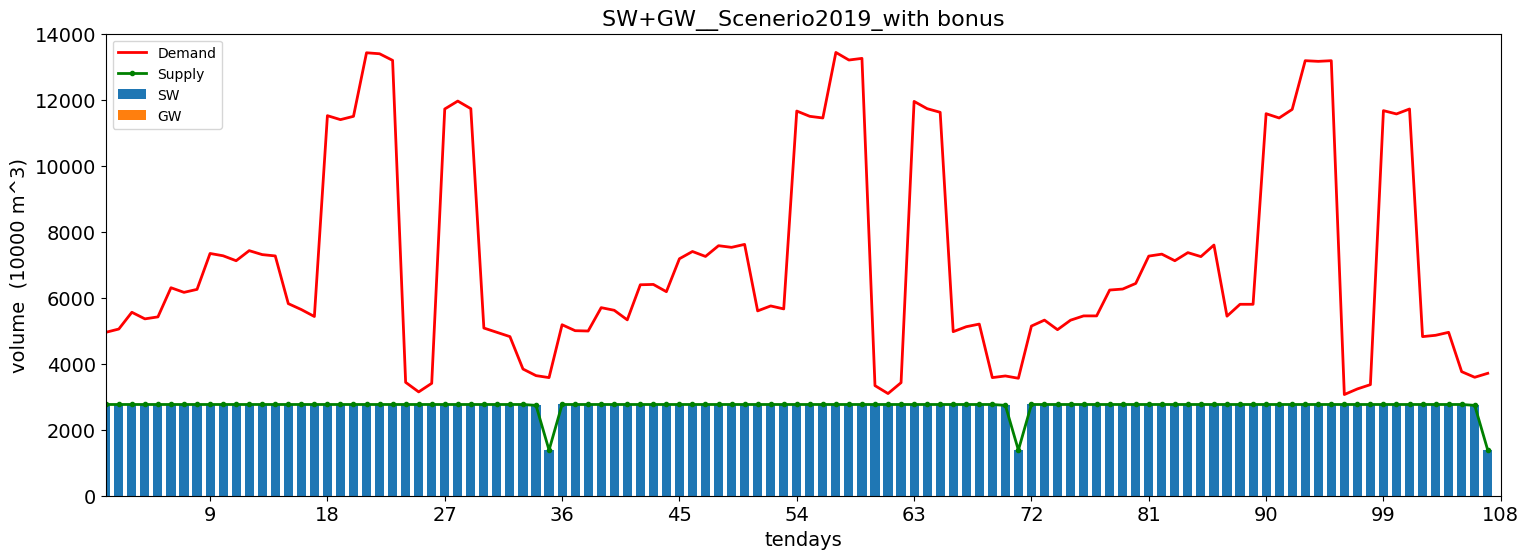

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
end=108
policy_type='_with bonus'

df = pd.DataFrame({'SW':SW[:end],
                   'GW':GW[:end],
                   'Supply':Sup[:end],
                   'Demand':D[:end],
                   'ith period of tendays':[i for i in range(1,end+1)],
                   'deficit':deficit[:end],
                   'Storage':S[:end],
                   #'h_min':h[:end],
                   'Inflow':inflow[:end],
                   'deficit_rate':[(b-a)/b*100 for a,b in zip(Sup[:end],D[:end])],
                   'reward':rewards[:end],
                   #'h_avg':Z_mean[:end]
                  }) 


ax = df[['SW','GW']].plot(kind='bar', stacked=True, figsize=(18,6), width=0.7,
                          xlim=[1,end], ylim=[0,14000], xticks=[9*i for i in range(1,21)], fontsize=14)
df['Demand'].plot(kind='line', color='#FF0000', lw=2, xlim=[1,end],legend=True)
df['Supply'].plot(kind='line', style='g.-', lw=2, xlim=[1,end],legend=True)
ax.set_title('SW+GW__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("volume  (10000 m^3)", fontsize=14)
ax.legend()

18.332511727122203
0.16974547895483522


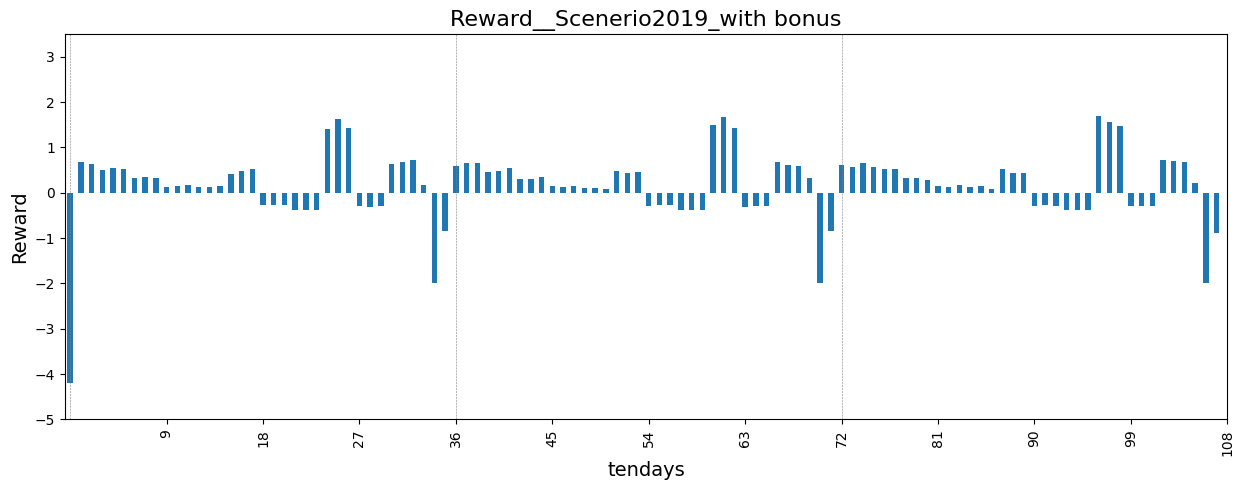

In [14]:
#reward
ax = df['reward'].plot(kind='bar', figsize=(15,5), lw=1.5, xlim=[1,end], ylim=[-5,3.5], 
                        style='r.-', xticks=[9*i for i in range(1,13)], fontsize=10)
#ax.set_title('deficit_rate', fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("Reward", fontsize=14)
ax.set_title('Reward__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)

for i in range(4):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")


print(df['reward'].sum())
print(df['reward'].mean())

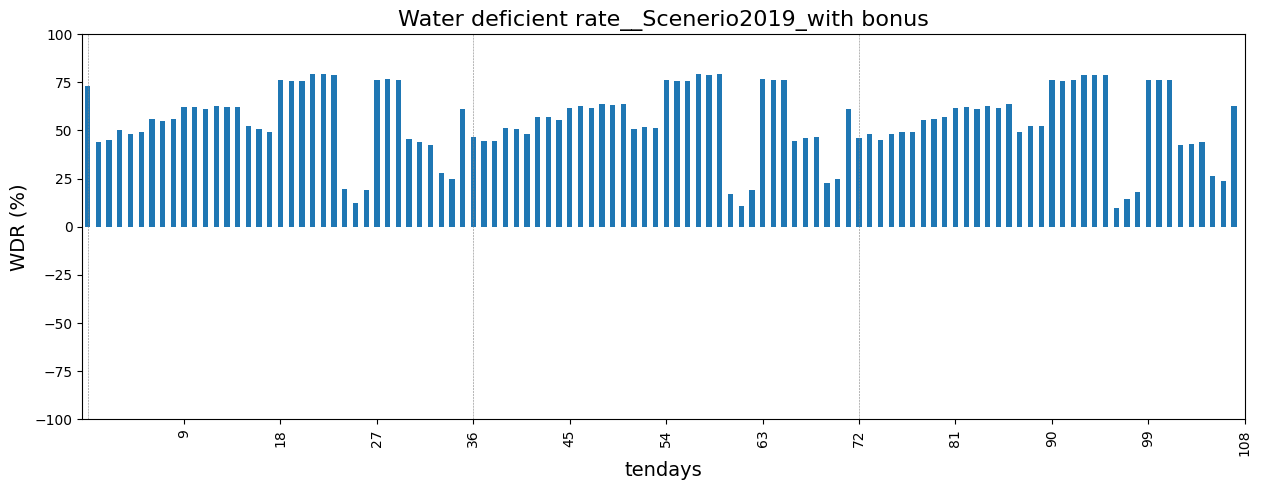

In [15]:
ax = df['deficit_rate'].plot(kind='bar', figsize=(15,5), lw=1.5, xlim=[1,end], ylim=[-100,100], 
                        style='r.-', xticks=[9*i for i in range(1,13)], fontsize=10)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("WDR (%)", fontsize=14)
ax.set_title('Water deficient rate__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")

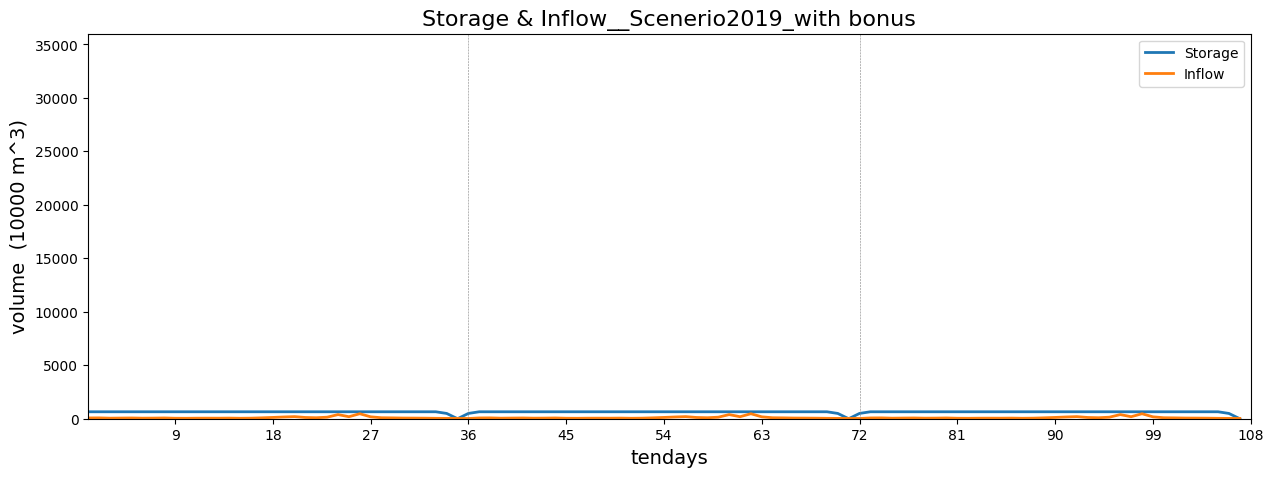

In [16]:
ax = df[['Storage','Inflow']].plot(kind='line', lw='2', figsize=(15,5),xlim=[1,end], ylim=[0,36000], xticks=[9*i for i in range(1,13)])
ax.set_title('Storage & Inflow__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("volume  (10000 m^3)", fontsize=14)
ax.legend()

for i in range(4):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")

In [ ]:
ax = df['GW'].plot(kind='bar', color='darkorange', figsize=(15,5), xlim=[1,180],ylim=[0,1000],width=0.4, xticks=[9*i for i in range(1,21)], legend=True)
ax2 = df['h_min'].plot(kind='line', secondary_y = True,  lw=2, color='#FF0000', legend=True)
ax3 = df['h_avg'].plot(kind='line', secondary_y = True,  lw=2, color='green', legend=True)
ax.set_title('GW pumping & Groundwater Head__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("groundwater pumping  (10000 m^3)", fontsize=14)

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")
ax2.axhline(0, color="grey",lw=0.6, linestyle="dashed")
    
ax2.set_ylabel("groundwater head (m)", fontsize=14)
ax2.set_ylim(-50, 100)
ax.legend(loc=2)
ax2.legend(loc=1)

